Use data from Kaggle to model the outcome of certain pairings between teams, given their rank, points, and the weighted point difference with the opponent.

# Data I/O

- [FIFA rankings from 1993 to 2018 (courtesy of Tadhg Fitzgerald](https://www.kaggle.com/tadhgfitzgerald/fifa-international-soccer-mens-ranking-1993now))
    - This one I used to get the FIFA ranking and points for the teams, which is a monthly changing rank previously shown as a [decent predictor](http://www.sportingintelligence.com/2014/06/20/upsets-giant-killings-adios-bye-bye-fifa-rankings-still-ahead-in-predicting-results-200601/) of team performance
- [International Soccer matches from 1872 to 2018 (courtesy of Mart Jürisoo](https://www.kaggle.com/martj42/international-football-results-from-1872-to-2017))
    - This I will use to find out how much the difference in point, ranks and the current rank of the team affects the outocme of a match
- [FIFA World Cup 2018 data set (courtesy of Nuggs](https://www.kaggle.com/ahmedelnaggar/fifa-worldcup-2018-dataset))

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',100)
from matplotlib import pyplot as plt

rankings = pd.read_csv('data/fifa_ranking.csv')
rankings = rankings.loc[:,['rank', 'country_full', 'country_abrv', 'cur_year_avg_weighted', 'rank_date', 
                           'two_year_ago_weighted', 'three_year_ago_weighted']]
rankings = rankings.replace({"IR Iran": "Iran"})
rankings['weighted_points'] =  rankings['cur_year_avg_weighted'] + rankings['two_year_ago_weighted'] + rankings['three_year_ago_weighted']
rankings['rank_date'] = pd.to_datetime(rankings['rank_date'])

matches = pd.read_csv('data/results.csv')
matches =  matches.replace({'Germany DR': 'Germany', 'China': 'China PR'})
matches['date'] = pd.to_datetime(matches['date'])

world_cup = pd.read_csv('data/World Cup 2018 Dataset.csv')
world_cup = world_cup.loc[:, ['Team', 'Group', 'First match \nagainst', 'Second match\n against', 'Third match\n against']]
world_cup = world_cup.dropna(how='all')
world_cup = world_cup.replace({"IRAN": "Iran", 
                               "Costarica": "Costa Rica", 
                               "Porugal": "Portugal", 
                               "Columbia": "Colombia", 
                               "Korea" : "Korea Republic"})
world_cup = world_cup.set_index('Team')

# Feature extraction

I join the matches with the ranks of the different teams. 

Then extract some features:
- point and rank differences
- if the game was for some stakes, because my naive view was that typically friendly matches are harder to predict (TODO differentiate the WC matches from the rest)

In [2]:
# I want to have the ranks for every day 
rankings = rankings.set_index(['rank_date'])\
            .groupby(['country_full'], group_keys=False)\
            .resample('D').first()\
            .fillna(method='ffill')\
            .reset_index()

# join the ranks
matches = matches.merge(rankings, 
                        left_on=['date', 'home_team'], 
                        right_on=['rank_date', 'country_full'])
matches = matches.merge(rankings, 
                        left_on=['date', 'away_team'], 
                        right_on=['rank_date', 'country_full'], 
                        suffixes=('_home', '_away'))

In [3]:
# feature generation
matches['rank_difference'] = matches['rank_home'] - matches['rank_away']
matches['average_rank'] = (matches['rank_home'] + matches['rank_away'])/2
matches['point_difference'] = matches['weighted_points_home'] - matches['weighted_points_away']
matches['score_difference'] = matches['home_score'] - matches['away_score']
matches['is_won'] = matches['score_difference'] > 0 # take draw as lost
matches['is_stake'] = matches['tournament'] != 'Friendly'

# # how many days the different teams were able to rest but this turned out to be not important enough to be worth the hassle
# max_rest = 30
# matches['rest_days'] = matches.groupby('home_team').diff()['date'].dt.days.clip(0,max_rest).fillna(max_rest)

# # include the participant countries as a one hot vector but that did not appear to be a strong predictor either
# matches['wc_participant'] = matches['home_team'] * matches['home_team'].isin(world_cup.index.tolist())
# matches['wc_participant'] = matches['wc_participant'].replace({'':'Other'})
# matches = matches.join(pd.get_dummies(matches['wc_participant']))

In [4]:
matches.tail()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,rank_date_home,rank_home,country_full_home,country_abrv_home,cur_year_avg_weighted_home,two_year_ago_weighted_home,three_year_ago_weighted_home,weighted_points_home,rank_date_away,rank_away,country_full_away,country_abrv_away,cur_year_avg_weighted_away,two_year_ago_weighted_away,three_year_ago_weighted_away,weighted_points_away,rank_difference,average_rank,point_difference,score_difference,is_won,is_stake
18474,2018-06-07,Uruguay,Uzbekistan,3,0,Friendly,Montevideo,Uruguay,False,2018-06-07,14.0,Uruguay,URU,486.28,168.44,119.85,774.57,2018-06-07,95.0,Uzbekistan,UZB,66.85,93.52,40.74,201.11,-81.0,54.5,573.46,3,True,False
18475,2018-06-07,Portugal,Algeria,3,0,Friendly,Lisbon,Portugal,False,2018-06-07,4.0,Portugal,POR,646.92,155.33,125.53,927.78,2018-06-07,66.0,Algeria,ALG,163.41,91.40,101.63,356.44,-62.0,35.0,571.34,3,True,False
18476,2018-06-07,Korea Republic,Bolivia,0,0,Friendly,Innsbruck,Austria,True,2018-06-07,57.0,Korea Republic,KOR,162.13,91.79,65.96,319.88,2018-06-07,59.0,Bolivia,BOL,291.14,66.68,21.32,379.14,-2.0,58.0,-59.26,0,False,False
18477,2018-06-07,Iceland,Ghana,2,2,Friendly,Reykjavík,Iceland,False,2018-06-07,22.0,Iceland,ISL,438.64,90.61,96.64,625.89,2018-06-07,47.0,Ghana,GHA,261.21,99.90,92.63,453.74,-25.0,34.5,172.15,0,False,False
18478,2018-06-07,India,New Zealand,1,2,Friendly,Mumbai,India,False,2018-06-07,97.0,India,IND,196.24,25.50,17.00,238.74,2018-06-07,120.0,New Zealand,NZL,78.58,76.45,3.81,158.84,-23.0,108.5,79.90,-1,False,False


# Modeling

I used a simple Logistic regression, which yielded already rather good performance

In [46]:
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

X, y = matches.loc[:,['average_rank', 'rank_difference', 'point_difference', 'is_stake']], matches['is_won'].astype(int)
# X, y = matches.loc[:,['average_rank', 'rank_difference', 'point_difference', 'is_stake']], matches.loc[:,['home_score', 'away_score']].values
# X, y = matches.loc[:,['average_rank', 'rank_difference', 'point_difference', 'is_stake']], matches['home_score']
# X, y = matches.loc[:,['average_rank', 'rank_difference', 'point_difference', 'is_stake']], matches['score_difference']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# max_depth = 30
# regr_rf = RandomForestRegressor(n_estimators=10, max_depth=max_depth, random_state=2)
logreg = linear_model.LogisticRegression(C=1e-5)
features = PolynomialFeatures(degree=2)
model1 = Pipeline([
    ('polynomial_features', features),
    ('logistic_regression', logreg)
#     ('random_forest_regression', regr_rf)
])
model1 = model1.fit(X_train, y_train)

In [25]:
import xgboost as xgb
from sklearn import metrics
### 学習
# XGBoostの実行


denom = 0
fold = 5 #Change to 5, 1 for Kaggle Limits
for i in range(fold):
    params = {
        'eta': 0.03333,
        'max_depth': 4,
#         'objective': 'multi:softprob',
        'eval_metric': 'mlogloss',
#         'num_class': 9,
        'num_class': 2,
        'seed': i,
        'silent': True,
#         'tree_method': 'gpu_hist'
    }
#     x1, x2, y1, y2 = model_selection.train_test_split(train, y, test_size=0.18, random_state=i)
    x1, x2, y1, y2 = train_test_split(X_train, y_train, test_size=0.2, random_state=i)
    watchlist = [(xgb.DMatrix(x1, y1), 'train'), (xgb.DMatrix(x2, y2), 'valid')]
    model = xgb.train(params, xgb.DMatrix(x1, y1), 1000,  watchlist, verbose_eval=50, early_stopping_rounds=100)
#     score1 = metrics.log_loss(y2, model.predict(xgb.DMatrix(x2), ntree_limit=model.best_ntree_limit), labels = list(range(9)))
#     score1 = metrics.log_loss(y2, model.predict(xgb.DMatrix(x2), ntree_limit=model.best_ntree_limit))
#     print(score1)
    #if score < 0.9:
    if denom != 0:
#         pred = model.predict(xgb.DMatrix(test), ntree_limit=model.best_ntree_limit+80)
        pred = model.predict(xgb.DMatrix(X_test), ntree_limit=model.best_ntree_limit+80)
        preds += pred
    else:
#         pred = model.predict(xgb.DMatrix(test), ntree_limit=model.best_ntree_limit+80)
        pred = model.predict(xgb.DMatrix(X_test), ntree_limit=model.best_ntree_limit+80)
        preds = pred.copy()
    denom += 1
#     submission = pd.DataFrame(pred, columns=['class'+str(c+1) for c in range(9)])
    submission = pd.DataFrame(pred, columns=['is_won'])
#     submission['ID'] = pid
#     submission.to_csv('submission_xgb_fold_'  + str(i) + '.csv', index=False)
preds /= denom
submission = pd.DataFrame(preds, columns=['is_won'])
# submission['ID'] = pid
# submission.to_csv('submission.gz', index=False, compression='gzip')
# # print(r2_score(y_train, model.predict(X_train)))
# print(r2_score(y_test, preds))
# # print(mean_absolute_error(y_train, model.predict(X_train)))
# print(mean_absolute_error(y_test, preds))
# # print(mean_squared_error(y_train, model.predict(X_train)))
# print(mean_squared_error(y_test, preds))

[0]	train-mlogloss:0.687115	valid-mlogloss:0.687583
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 100 rounds.
[50]	train-mlogloss:0.592107	valid-mlogloss:0.608262
[100]	train-mlogloss:0.581743	valid-mlogloss:0.605992
[150]	train-mlogloss:0.578019	valid-mlogloss:0.606635
Stopping. Best iteration:
[89]	train-mlogloss:0.583089	valid-mlogloss:0.605717

[0]	train-mlogloss:0.687346	valid-mlogloss:0.687237
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 100 rounds.
[50]	train-mlogloss:0.596	valid-mlogloss:0.595257
[100]	train-mlogloss:0.585333	valid-mlogloss:0.588344
[150]	train-mlogloss:0.581863	valid-mlogloss:0.587746
[200]	train-mlogloss:0.578729	valid-mlogloss:0.587757
[250]	train-mlogloss:0.576004	valid-mlogloss:0.587672
[300]	train-mlogloss:0.573363	valid-mlogloss:0.587745
[350]	train-mlogloss:0.5710

In [34]:
print(preds.values.unique())
print(y_test.values)
type(preds[0])

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [36]:
preds.astype('int')

array([1, 0, 1, ..., 1, 1, 1])

Confusion matrix, without normalization
[[716 237]
 [371 524]]


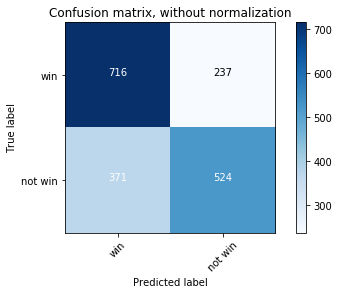

In [37]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cnf_matrix = confusion_matrix(y_test, preds.astype('int'))
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, 
                      classes=['win', 'not win'],
                      title='Confusion matrix, without normalization')

plt.show()

In [ ]:
# figures 
# fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
fpr, tpr, _ = roc_curve(y_test, preds)
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr)
ax.set_title('AUC score is {0:0.2}'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:,1])))
ax.set_aspect(1)

ax = plt.subplot(1,3,2)
cm = confusion_matrix(y_test, model.predict(X_test))
ax.imshow(cm, cmap='Blues', clim = (0, cm.max())) 

ax.set_xlabel('Predicted label')
ax.set_title('Performance on the Test set')

ax = plt.subplot(1,3,3)
cm = confusion_matrix(y_train, model.predict(X_train))
ax.imshow(cm, cmap='Blues', clim = (0, cm.max())) 
ax.set_xlabel('Predicted label')
ax.set_title('Performance on the Training set')
pass

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
print(r2_score(y_train, model.predict(X_train)))
print(r2_score(y_test, model.predict(X_test)))
print(mean_absolute_error(y_train, model.predict(X_train)))
print(mean_absolute_error(y_test, model.predict(X_test)))
print(mean_squared_error(y_train, model.predict(X_train)))
print(mean_squared_error(y_test, model.predict(X_test)))

In [ ]:
matches.loc[:,['home_team', 'away_team', 'home_score', 'away_score', 'rank_home', 'rank_away', 'average_rank', 'rank_difference', 'point_difference', 'is_stake']][matches['home_score']==4]

In [ ]:
matches.loc[:,['average_rank', 'rank_difference', 'point_difference', 'is_stake', 'home_score', 'away_score']].groupby(['home_score', 'away_score']).mean()

In [ ]:
X_train.tail(2)

In [ ]:
y_train

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

max_depth = 30
regr_multirf = MultiOutputRegressor(RandomForestRegressor(max_depth=max_depth,
                                                          random_state=0))
regr_multirf.fit(X_train, y_train)

regr_rf = RandomForestRegressor(max_depth=max_depth, random_state=2)
regr_rf.fit(X_train, y_train)

# Predict on new data
y_multirf = regr_multirf.predict(X_test)
y_rf = regr_rf.predict(X_test)

# Plot the results
plt.figure()
s = 50
a = 0.4
plt.scatter(y_test[:, 0], y_test[:, 1], edgecolor='k',
            c="navy", s=s, marker="s", alpha=a, label="Data")
# plt.scatter(y_multirf[:, 0], y_multirf[:, 1], edgecolor='k',
#             c="cornflowerblue", s=s, alpha=a,
#             label="Multi RF score=%.2f" % regr_multirf.score(X_test, y_test))
plt.scatter(y_rf[:, 0], y_rf[:, 1], edgecolor='k',
            c="c", s=s, marker="^", alpha=a,
            label="RF score=%.2f" % regr_rf.score(X_test, y_test))
# plt.xlim([-6, 6])
# plt.ylim([-6, 6])
plt.xlim([0, 15])
plt.ylim([0, 15])
plt.xlabel("target 1")
plt.ylabel("target 2")
plt.title("Comparing random forests and the multi-output meta estimator")
plt.legend()
plt.show()

In [ ]:
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

In [ ]:
y_test.shape

In [ ]:
# pred_test = pd.DataFrame(model.predict(X_test), columns=['home_score_pred', 'away_score_pred'])
# pred_train = pd.DataFrame(model.predict(X_train), columns=['home_score_pred', 'away_score_pred'])
pred_test = pd.DataFrame(model.predict(X_test), columns=['home_score_pred'])
pred_train = pd.DataFrame(model.predict(X_train), columns=['home_score_pred'])

In [ ]:
matches_train, matches_test = train_test_split(matches, test_size=0.2, random_state=42)
result_train = matches_train.loc[:,['date', 'home_team', 'away_team', 'home_score', 'away_score']].copy()
result_train = pd.concat([result_train.reset_index(), pred_train.reset_index(drop=True)], axis=1)
# result_test['home_score_pred', 'away_score_pred'] = model.predict(X_test)
print(result_train.shape)
result_train.tail()

In [ ]:
matches_train, matches_test = train_test_split(matches, test_size=0.2, random_state=42)
result_test = matches_test.loc[:,['date', 'home_team', 'away_team', 'home_score', 'away_score']].copy()
result_test = pd.concat([result_test.reset_index(), pred_test.reset_index(drop=True)], axis=1)
# result_test['home_score_pred', 'away_score_pred'] = model.predict(X_test)
print(result_test.shape)
result_test.tail()

In [ ]:
# figures 
# fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
fpr, tpr, _ = roc_curve(y_test, model.predict(X_test))
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr)
ax.set_title('AUC score is {0:0.2}'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:,1])))
ax.set_aspect(1)

ax = plt.subplot(1,3,2)
cm = confusion_matrix(y_test, model.predict(X_test))
ax.imshow(cm, cmap='Blues', clim = (0, cm.max())) 

ax.set_xlabel('Predicted label')
ax.set_title('Performance on the Test set')

ax = plt.subplot(1,3,3)
cm = confusion_matrix(y_train, model.predict(X_train))
ax.imshow(cm, cmap='Blues', clim = (0, cm.max())) 
ax.set_xlabel('Predicted label')
ax.set_title('Performance on the Training set')
pass

I consider this pretty good performance, minding that soccer matches have typically only few goals scored and therefore making their outcome even more unpredictable. Nevertheless, let's look at the bad predictions and see where we are making mistakes more often.

array([0.7 , 0.75, 0.52, ..., 0.4 , 0.5 , 0.63])

Confusion matrix, without normalization
[[651 302]
 [297 598]]


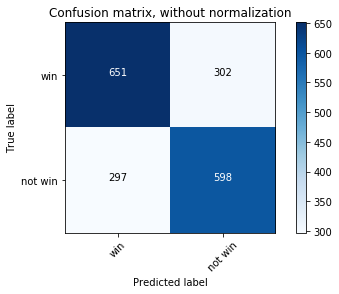

In [47]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cnf_matrix = confusion_matrix(y_test, model1.predict(X_test))
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, 
                      classes=['win', 'not win'],
                      title='Confusion matrix, without normalization')

plt.show()

In [ ]:
features = ['average_rank', 'rank_difference', 'point_difference']
wrongs = y_test != model.predict(X_test)

for feature in features:
    plt.figure()
    plt.title(feature)
    X_test.loc[wrongs, feature].plot.kde()
    X.loc[:, feature].plot.kde()
    plt.legend(['wrongs', 'all'])
    
print("Stakes distribution in the wrong predictions")
print(X_test.loc[wrongs, 'is_stake'].value_counts() / wrongs.sum())
print("Stakes distribution overall")
print(X['is_stake'].value_counts() / X.shape[0])

From these figures, we read 
- we predict worse for closer ranks
- lower ranks in general
- and somewhat for matches with no stakes (Friendly here)

Luckily, this implies that for the world cup our predicitons may be somewhat even better

# World Cup simulation

## Group rounds

In [ ]:
# let's define a small margin when we safer to predict draw then win
margin = 0.05

# let's define the rankings at the time of the World Cup
world_cup_rankings = rankings.loc[(rankings['rank_date'] == rankings['rank_date'].max()) & 
                                    rankings['country_full'].isin(world_cup.index.unique())]
world_cup_rankings = world_cup_rankings.set_index(['country_full'])

In [ ]:
from itertools import combinations

opponents = ['First match \nagainst', 'Second match\n against', 'Third match\n against']

world_cup['points'] = 0
world_cup['total_prob'] = 0

for group in set(world_cup['Group']):
    print('___Starting group {}:___'.format(group))
    for home, away in combinations(world_cup.query('Group == "{}"'.format(group)).index, 2):
        print("{} vs. {}: ".format(home, away), end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
        home_rank = world_cup_rankings.loc[home, 'rank']
        home_points = world_cup_rankings.loc[home, 'weighted_points']
        opp_rank = world_cup_rankings.loc[away, 'rank']
        opp_points = world_cup_rankings.loc[away, 'weighted_points']
        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        row['point_difference'] = home_points - opp_points
        
        home_win_prob = model.predict_proba(row)[:,1][0]
        world_cup.loc[home, 'total_prob'] += home_win_prob
        world_cup.loc[away, 'total_prob'] += 1-home_win_prob
        
        points = 0
        if home_win_prob <= 0.5 - margin:
            print("{} wins with {:.2f}".format(away, 1-home_win_prob))
            world_cup.loc[away, 'points'] += 3
        if home_win_prob > 0.5 - margin:
            points = 1
        if home_win_prob >= 0.5 + margin:
            points = 3
            world_cup.loc[home, 'points'] += 3
            print("{} wins with {:.2f}".format(home, home_win_prob))
        if points == 1:
            print("Draw")
            world_cup.loc[home, 'points'] += 1
            world_cup.loc[away, 'points'] += 1

## Single-elimination rounds

In [ ]:
pairing = [0,3,4,7,8,11,12,15,1,2,5,6,9,10,13,14]

world_cup = world_cup.sort_values(by=['Group', 'points', 'total_prob'], ascending=False).reset_index()
world_cup

In [ ]:
next_round_wc = world_cup.groupby('Group').nth([0, 1]) # select the top 2
next_round_wc = next_round_wc.reset_index()
next_round_wc = next_round_wc.loc[pairing]
next_round_wc = next_round_wc.set_index('Team')

finals = ['round_of_16', 'quarterfinal', 'semifinal', 'final']

labels = list()
odds = list()

for f in finals:
    print("___Starting of the {}___".format(f))
    iterations = int(len(next_round_wc) / 2)
    winners = []

    for i in range(iterations):
        home = next_round_wc.index[i*2]
        away = next_round_wc.index[i*2+1]
        print("{} vs. {}: ".format(home,
                                   away), 
                                   end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
        home_rank = world_cup_rankings.loc[home, 'rank']
        home_points = world_cup_rankings.loc[home, 'weighted_points']
        opp_rank = world_cup_rankings.loc[away, 'rank']
        opp_points = world_cup_rankings.loc[away, 'weighted_points']
        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        row['point_difference'] = home_points - opp_points

        home_win_prob = model.predict_proba(row)[:,1][0]
        if model.predict_proba(row)[:,1] <= 0.5:
            print("{0} wins with probability {1:.2f}".format(away, 1-home_win_prob))
            winners.append(away)
        else:
            print("{0} wins with probability {1:.2f}".format(home, home_win_prob))
            winners.append(home)

        labels.append("{}({:.2f}) vs. {}({:.2f})".format(world_cup_rankings.loc[home, 'country_abrv'], 
                                                        1/home_win_prob, 
                                                        world_cup_rankings.loc[away, 'country_abrv'], 
                                                        1/(1-home_win_prob)))
        odds.append([home_win_prob, 1-home_win_prob])
                
    next_round_wc = next_round_wc.loc[winners]
    print("\n")

# Let's see a visualization 

In [ ]:
# import networkx as nx
# import pydot
# from networkx.drawing.nx_pydot import graphviz_layout

# node_sizes = pd.DataFrame(list(reversed(odds)))
# scale_factor = 0.3 # for visualization
# G = nx.balanced_tree(2, 3)
# pos = graphviz_layout(G, prog='twopi', args='')
# centre = pd.DataFrame(pos).mean(axis=1).mean()

# plt.figure(figsize=(10, 10))
# ax = plt.subplot(1,1,1)
# # add circles 
# circle_positions = [(235, 'black'), (180, 'blue'), (120, 'red'), (60, 'yellow')]
# [ax.add_artist(plt.Circle((centre, centre), 
#                           cp, color='grey', 
#                           alpha=0.2)) for cp, c in circle_positions]

# # draw first the graph
# nx.draw(G, pos, 
#         node_color=node_sizes.diff(axis=1)[1].abs().pow(scale_factor), 
#         node_size=node_sizes.diff(axis=1)[1].abs().pow(scale_factor)*2000, 
#         alpha=1, 
#         cmap='Reds',
#         edge_color='black',
#         width=10,
#         with_labels=False)

# # draw the custom node labels
# shifted_pos = {k:[(v[0]-centre)*0.9+centre,(v[1]-centre)*0.9+centre] for k,v in pos.items()}
# nx.draw_networkx_labels(G, 
#                         pos=shifted_pos, 
#                         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=.5, alpha=1),
#                         labels=dict(zip(reversed(range(len(labels))), labels)))

# texts = ((10, 'Best 16', 'black'), (70, 'Quarter-\nfinal', 'blue'), (130, 'Semifinal', 'red'), (190, 'Final', 'yellow'))
# [plt.text(p, centre+20, t, 
#           fontsize=12, color='grey', 
#           va='center', ha='center') for p,t,c in texts]
# plt.axis('equal')
# plt.title('Single-elimination phase\npredictions with fair odds', fontsize=20)
# plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor


# Create a random dataset
rng = np.random.RandomState(1)
X = np.sort(200 * rng.rand(600, 1) - 100, axis=0)
y = np.array([np.pi * np.sin(X).ravel(), np.pi * np.cos(X).ravel()]).T
y += (0.5 - rng.rand(*y.shape))

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=400,
                                                    random_state=4)

max_depth = 30
regr_multirf = MultiOutputRegressor(RandomForestRegressor(max_depth=max_depth,
                                                          random_state=0))
regr_multirf.fit(X_train, y_train)

regr_rf = RandomForestRegressor(max_depth=max_depth, random_state=2)
regr_rf.fit(X_train, y_train)

# Predict on new data
y_multirf = regr_multirf.predict(X_test)
y_rf = regr_rf.predict(X_test)

# Plot the results
plt.figure()
s = 50
a = 0.4
plt.scatter(y_test[:, 0], y_test[:, 1], edgecolor='k',
            c="navy", s=s, marker="s", alpha=a, label="Data")
plt.scatter(y_multirf[:, 0], y_multirf[:, 1], edgecolor='k',
            c="cornflowerblue", s=s, alpha=a,
            label="Multi RF score=%.2f" % regr_multirf.score(X_test, y_test))
plt.scatter(y_rf[:, 0], y_rf[:, 1], edgecolor='k',
            c="c", s=s, marker="^", alpha=a,
            label="RF score=%.2f" % regr_rf.score(X_test, y_test))
plt.xlim([-6, 6])
plt.ylim([-6, 6])
plt.xlabel("target 1")
plt.ylabel("target 2")
plt.title("Comparing random forests and the multi-output meta estimator")
plt.legend()
plt.show()